In [1]:
!pip install statsmodels

     |████████████████████████████████| 9.5 MB 5.2 MB/s eta 0:00:01     |██████████▌                     | 3.1 MB 5.2 MB/s eta 0:00:02
     |████████████████████████████████| 231 kB 33.6 MB/s eta 0:00:01


In [64]:
import os
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
import h5py
import random
from scipy import ndimage
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn
import tempfile
import datetime
from statsmodels.stats.proportion import proportion_confint
from functions.auc_delong_xu import auc_ci_Delong

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.layers.merge import concatenate
from tensorflow.keras import regularizers
from keras import backend as K

In [4]:
tf.__version__

'2.4.0'

### Import data from HD5File

Checking the data

In [3]:
PATH_3D_H5 = 'Images/tof_data.hdf5'

In [4]:
with h5py.File(PATH_3D_H5, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)
    print(dd['stroke'].shape)

['X', 'pat', 'path', 'stroke']
(508, 128, 112, 40)
(508,)


In [5]:
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File(PATH_3D_H5, 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    
    # Image matrices
    X = h5["X"][:]
    # Patient ID's
    pat = h5["pat"][:]
    # Path to images
    path = decode_data(h5["path"][:])
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
    
print(len(X), len(Y_pat), len(pat), len(path))

H5-file:  ['X', 'pat', 'path', 'stroke']
508 508 508 508


### Train, validation, test split (vgl. NB from Lisa)

There are 508 patients with TOF-MRA images. We split the dataset in a training, validation and test set.
- Training set: 304 images (~60%) -> 211 stroke, 93 non-stroke
- Validation set: 102 images (~20%) -> 70 stroke, 32 non-stroke
- Test set: 102 images (~20%) -> 70 stroke, 32 non-stroke

In every set there is the same percentage of stroke patients vs. non stroke patients (approx. 69% vs. 31%)

In [6]:
# consider stroke and no-stroke patients separately:
idx = np.where(Y_pat == 1)[0]
stroke_patients = np.unique(pat[idx])
idx = np.where(Y_pat == 0)[0]
non_stroke_patients = np.unique(pat[idx])
print(len(stroke_patients), len(non_stroke_patients))

351 157


In [7]:
# randomly shuffle the stroke and non-stroke patients
np.random.seed(1)
stroke_patients_test = np.random.choice(stroke_patients, size=len(stroke_patients), replace=False)
non_stroke_patients_test = np.random.choice(non_stroke_patients, size=len(non_stroke_patients), replace=False)

In [8]:
#test set
np.random.seed(1)
test_tmp = np.concatenate([stroke_patients_test[:70], non_stroke_patients_test[:31]], axis=0)
test = np.random.choice(test_tmp, size=len(test_tmp), replace=False)
len(test)

101

In [9]:
stroke_patients_run = [i for i in stroke_patients if i not in test]
non_stroke_patients_run = [i for i in non_stroke_patients if i not in test]

# randomply shuffle the data
np.random.seed(100)
stroke_patients_tmp = np.random.choice(stroke_patients_run, size=len(stroke_patients_run), replace=False)
non_stroke_patients_tmp = np.random.choice(non_stroke_patients_run, size=len(non_stroke_patients_run), replace=False)
print(len(stroke_patients_tmp), len(non_stroke_patients_tmp))

281 126


In [10]:
train_tmp = np.concatenate([stroke_patients_tmp,non_stroke_patients_tmp], axis=0)
len(train_tmp)

407

In [11]:
# randomly shuffle the datasets such that stroke and no-stroke patients are mixed
np.random.seed(100)
train = np.random.choice(train_tmp, size=len(train_tmp), replace=False)
test = np.random.choice(test, size=len(test), replace=False)
print(len(train), len(test))

407 101


In [12]:
def get_datasets(set_i, X, Y_pat, pat, path):
    Y_pat_set = []
    pat_set = []
    path_set = []
    # Find the indices corresponding to the patient_i in set_i
    idx = [i for i, pat_i in enumerate(pat) if pat_i in set_i]
    X_set = X[idx,:,:,:]
    for i in idx:
        Y_pat_set.append(Y_pat[i])
        pat_set.append(pat[i])
        path_set.append(path[i])     
    return(X_set, np.array(Y_pat_set), np.array(pat_set), np.array(path_set))

In [251]:
X_train, Y_train, pat_train, path_train = get_datasets(train, X, Y_pat, pat, path)
#X_valid, Y_valid, pat_valid, path_valid = get_datasets(valid, X, Y_pat, pat, path)
X_test, Y_test, pat_test, path_test = get_datasets(test, X, Y_pat, pat, path)

In [14]:
#for softmax
Y_train = to_categorical(Y_train)
#Y_valid = to_categorical(Y_valid)
Y_test = to_categorical(Y_test)

### Preprocess data

In [252]:
IMAGE_DIMENSION = (64, 56, 20)
#IMAGE_DIMENSION = (96, 84, 30)
#IMAGE_DIMENSION = (128, 112, 40)

In [253]:
def normalize_array(array):
    min = np.min(array)
    max = np.max(array)
    normalized = (array - min) / (max - min)
    return normalized

In [254]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_width = IMAGE_DIMENSION[0]
    desired_height = IMAGE_DIMENSION[1]
    desired_depth = IMAGE_DIMENSION[2]
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    img = normalize_array(img)
    return img

In [255]:
X_train = np.array([resize_volume(img) for img in X_train])
#X_valid= np.array([resize_volume(img) for img in X_valid])
X_test = np.array([resize_volume(img) for img in X_test])

In [256]:
X_train = np.expand_dims(X_train, axis = 4)
X_train.shape

(407, 64, 56, 20, 1)

In [257]:
#X_valid = np.expand_dims(X_valid, axis = 4)
#X_valid.shape
X_test = np.expand_dims(X_test, axis = 4)
X_test.shape

(101, 64, 56, 20, 1)

In [21]:
np.min(X_train[4])

0.0

In [22]:
np.max(X_train[4])

1.0

In [337]:
##all elements between -0.5 and 0.5
X_train = X_train - 0.5
X_valid = X_valid - 0.5

In [338]:
print(np.min(X_train[0]), np.max(X_train[0]))

-0.5 0.5


### Data Augmentation

Zoom images

In [23]:
# zoom
def random_zoom3d(X_im, min_zoom, max_zoom):
    z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)

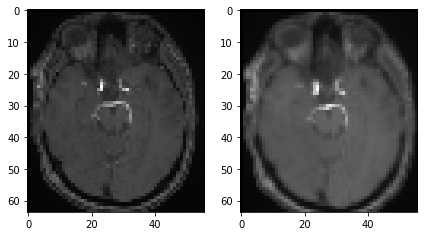

In [321]:
x = X_train[0]
X_aug = random_zoom3d(x, 0.8,1.00)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

Rotate images

In [24]:
# rotate
def random_rotate3d(X_im, min_angle_xy, max_angle_xy, min_angle_xz, max_angle_xz, min_angle_yz, max_angle_yz):
    angle_xy = np.random.uniform(min_angle_xy, max_angle_xy)
    angle_xz = np.random.uniform(min_angle_xz, max_angle_xz)
    angle_yz = np.random.uniform(min_angle_yz, max_angle_yz)
    rotation_axis = np.random.choice([0,1,2])
    if(rotation_axis == 0):
        X_im = ndimage.rotate(X_im, angle = angle_xy, axes = (0,1), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 1):
        X_im = ndimage.rotate(X_im, angle = angle_xz, axes = (0,2), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 2):
        X_im = ndimage.rotate(X_im, angle = angle_yz, axes = (1,2), mode = "nearest", reshape = False, order = 3)
    return X_im

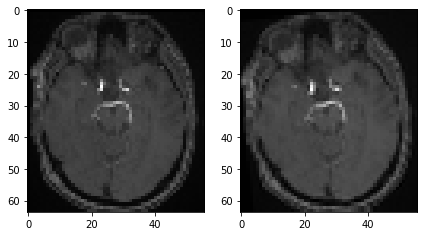

In [294]:
x = X_train[0]
X_aug = random_rotate3d(x, -20, 20, -10, 10, -5, 5)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

Shifting images

In [25]:
# shifting
def random_shift3d(X_im, min_shift_x, max_shift_x, min_shift_y, max_shift_y, min_shift_z, max_shift_z):
    x_shift = np.random.uniform(min_shift_x, max_shift_x)
    y_shift = np.random.uniform(min_shift_y, max_shift_y)
    z_shift = np.random.uniform(min_shift_z, max_shift_z)
    return ndimage.shift(X_im, [x_shift, y_shift, z_shift, 0], mode = "nearest", order = 0)

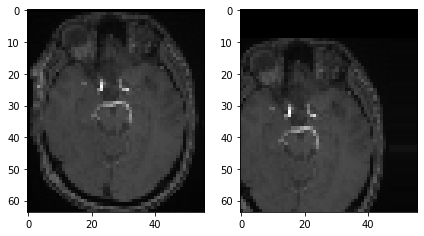

In [286]:
x = X_train[0]
X_aug = random_shift3d(x, -10, 10, -10, 10, 0, 0)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

Flipping images

In [26]:
def random_flip3d(X_im):
    axis = np.random.choice([0,1])
    if(axis == 0): # vertical flip
        X_im = X_im[:,::-1,:,:]
        # X_im = X_im[::-1,:,:,:] #horizontal
        # X_im = np.asarray(X_im).swapaxes(0, 1)#left, right flip
    return X_im

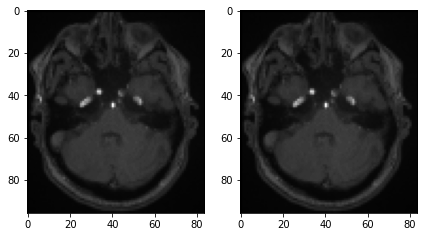

In [147]:
x = X_train[0]
X_aug = random_flip3d(x)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

Gauss filter

In [27]:
# Gauss filter (Glättung, Mittelwertberechnung per Pixel basierend auf umgebenden Pixeln ausgewählt mit Gaussfkt.)
def random_gaussianfilter3d(X_im, sigma_max):
    sigma = np.random.uniform(0, sigma_max)
    return ndimage.gaussian_filter(X_im, sigma, mode = "nearest")

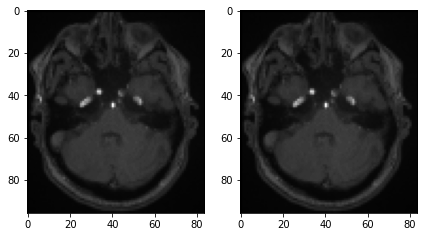

In [150]:
x = X_train[0]
X_aug = random_gaussianfilter3d(x, 0.2)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

In [29]:
@tf.function
def augment_3d_many(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        if IMAGE_DIMENSION == (128, 112, 64):
            #volume = random_zoom3d(volume, 0.8, 1.3)
            volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
            volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
            #volume = random_flip3d(volume)
            #volume = random_gaussianfilter3d(volume, 0.2)
            
        if IMAGE_DIMENSION == (96,84,30):
            volume = random_zoom3d(volume, 0.90,1.1)
            volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
            volume = random_shift3d(volume, -5, 5, -5, 5, 0, 0)
            volume = random_flip3d(volume)
            volume = random_gaussianfilter3d(volume, 0.2)
            
        if IMAGE_DIMENSION == (64,56,20):
            #volume = random_zoom3d(volume, 0.95,1.05) 
            volume = random_rotate3d(volume, -10, 10, -5, 5, -5, 5)
            volume = random_shift3d(volume, -5, 5, -5, 5, 0, 0) #do not shift in z direction
            #volume = random_flip3d(volume)
            #volume = random_gaussianfilter3d(volume, 0.2)
            
        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [176]:
@tf.function
def augment_3d_one(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        rand = np.random.randint(0,6)
        
        if IMAGE_DIMENSION == (128, 112, 64):
            if rand == 0:
                volume = random_zoom3d(volume, 0.8, 1.3)
            if rand == 1:
                volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
            if rand == 2:
                volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
            if rand == 3:
                volume = random_flip3d(volume)
            if rand == 4:
                volume = random_gaussianfilter3d(volume, 0.2)
            if rand == 5:
                volume = volume
            
        if IMAGE_DIMENSION == (64,56,20):
            if rand == 0:
                volume = random_zoom3d(volume, 0.8,1.00) 
            if rand == 1:
                volume = random_rotate3d(volume, -20, 20, -10, 10, 0, 0)
            if rand == 2:
                #volume = random_shift3d(volume, -5, 5, -5, 5, 0, 0) #do not shift in z direction
                volume = random_shift3d(volume, -10, 10, -10, 10, 0, 0) #do not shift in z direction
            if rand == 3:
                volume = random_flip3d(volume)
            if rand == 4:
                volume = random_gaussianfilter3d(volume, 0.2)
            if rand == 5:
                volume = volume

        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [201]:
@tf.function
def augment_3d_two(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        rand = np.random.randint(0,6, size = 2)
            
        if IMAGE_DIMENSION == (64,56,20):
            if 0 in rand:
                volume = volume
                rand = np.array([0,0])
            if 1 in rand:
                volume = random_rotate3d(volume, -20, 20, -10, 10, 0, 0)
            if 2 in rand:
                #volume = random_shift3d(volume, -5, 5, -5, 5, 0, 0) #do not shift in z direction
                volume = random_shift3d(volume, -10, 10, -10, 10, 0, 0) #do not shift in z direction
            if 3 in rand:
                volume = random_flip3d(volume)
            if 4 in rand:
                volume = random_gaussianfilter3d(volume, 0.2)
            if 5 in rand:
                volume = random_zoom3d(volume, 0.8,1.00) 

        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [260]:
def train_preprocessing(volume, label):
    volume = augment_3d_one(volume)
    return volume, label

### Define data loaders

In [191]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

In [107]:
train_loader

<TensorSliceDataset shapes: ((64, 56, 20, 1), (2,)), types: (tf.float64, tf.float32)>

In [254]:
batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .batch(batch_size)
    .prefetch(2)
)

In [193]:
train_dataset

<PrefetchDataset shapes: ((None, 64, 56, 20, 1), (None, 2)), types: (tf.float64, tf.float32)>

Dimension of the CT scan is: (64, 56, 20, 1)


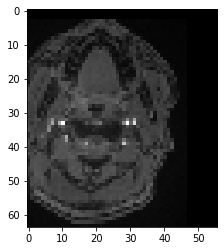

In [215]:
data = resampled_data.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 0]), cmap="gray")

In [19]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    fig = plt.gcf()
    plt.show()
    fig.savefig('Rotatet slices', dpi = 100,bbox_inches='tight')

In [ ]:
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 112, image[:, :, :40])

Balanced dataset with tf.data

In [258]:
#bool_train_labels = Y_train[:,1] != 0
bool_train_labels = Y_train != 0 #sigmoid
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]
pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [259]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [261]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

batch_size = 4
# Augment the on the fly during training.
resampled_data = (
    
    resampled_ds.shuffle(buffer_size = (len(pos_features)*2), reshuffle_each_iteration=True)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .batch(batch_size)
    .prefetch(2)
)

In [262]:
pos = len(pos_features)
neg = len(neg_features)
total = pos + neg
resampled_steps_per_epoch = np.ceil(2.0*pos/batch_size)
resampled_steps_per_epoch

141.0

In [263]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.62
Weight for class 1: 0.72


### Train CNN

In [38]:
w = IMAGE_DIMENSION[0]
h = IMAGE_DIMENSION[1]
d = IMAGE_DIMENSION[2]

In [33]:
def get_model(width=w, height=h, depth=d):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding = 'same')(inputs)
    #x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding = 'same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = 'same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = 'same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    #x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=32, activation="relu")(x)
    x = layers.Dropout(0.2)(x) 

    outputs = layers.Dense(units=2, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

In [264]:
def get_model(width=w, height=h, depth=d):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding = 'same')(inputs)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(units=8, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.2)(x) 

    outputs = layers.Dense(units=2, activation="softmax")(x)
    #outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

In [267]:
# Build model softmax
model = get_model(width=w, height=h, depth=d)
#model.load_weights(initial_weights)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 64, 56, 20, 1)]   0         
_________________________________________________________________
conv3d_121 (Conv3D)          (None, 64, 56, 20, 16)    448       
_________________________________________________________________
average_pooling3d_42 (Averag (None, 32, 28, 10, 16)    0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 32, 28, 10, 16)    64        
_________________________________________________________________
conv3d_122 (Conv3D)          (None, 32, 28, 10, 32)    13856     
_________________________________________________________________
average_pooling3d_43 (Averag (None, 16, 14, 5, 32)     0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 14, 5, 32)     128   

In [268]:
### define metrics
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')]

### prepare files for logging
if os.path.exists('results.csv'):
    os.remove('results.csv')
    
shutil.rmtree('History')
os.makedirs('History')
    
filepath = 'History/model.epoch{epoch:02d}.hdf5'
    
### define callback_list
callback_list = [
    keras.callbacks.ModelCheckpoint(filepath=filepath, save_freq='epoch', verbose=1), 
    keras.callbacks.CSVLogger('results.csv')]
    
model.compile(#loss = "categorical_crossentropy",
              loss = "binary_crossentropy",
              #optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              optimizer = keras.optimizers.RMSprop(learning_rate = 0.00001),
              metrics = metrics)

### Balanced model

In [269]:
epochs = 100
hist = model.fit(
    resampled_data,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1, callbacks=callback_list, 
    steps_per_epoch = resampled_steps_per_epoch,
    class_weight = class_weight)

Epoch 1/100
141/141 [==============================] - 7s 39ms/step - loss: 0.9194 - accuracy: 0.4394 - auc: 0.4457 - val_loss: 0.7453 - val_accuracy: 0.3069 - val_auc: 0.5756

Epoch 00001: saving model to History/model.epoch01.hdf5
Epoch 2/100
141/141 [==============================] - 5s 38ms/step - loss: 0.7797 - accuracy: 0.5051 - auc: 0.5526 - val_loss: 0.8273 - val_accuracy: 0.3069 - val_auc: 0.5311

Epoch 00002: saving model to History/model.epoch02.hdf5
Epoch 3/100
141/141 [==============================] - 5s 38ms/step - loss: 0.7711 - accuracy: 0.4842 - auc: 0.5452 - val_loss: 0.7763 - val_accuracy: 0.3069 - val_auc: 0.5680

Epoch 00003: saving model to History/model.epoch03.hdf5
Epoch 4/100
141/141 [==============================] - 5s 36ms/step - loss: 0.7531 - accuracy: 0.5188 - auc: 0.5822 - val_loss: 0.8658 - val_accuracy: 0.3069 - val_auc: 0.5332

Epoch 00004: saving model to History/model.epoch04.hdf5
Epoch 5/100
141/141 [==============================] - 5s 37ms/step 

KeyboardInterrupt: 

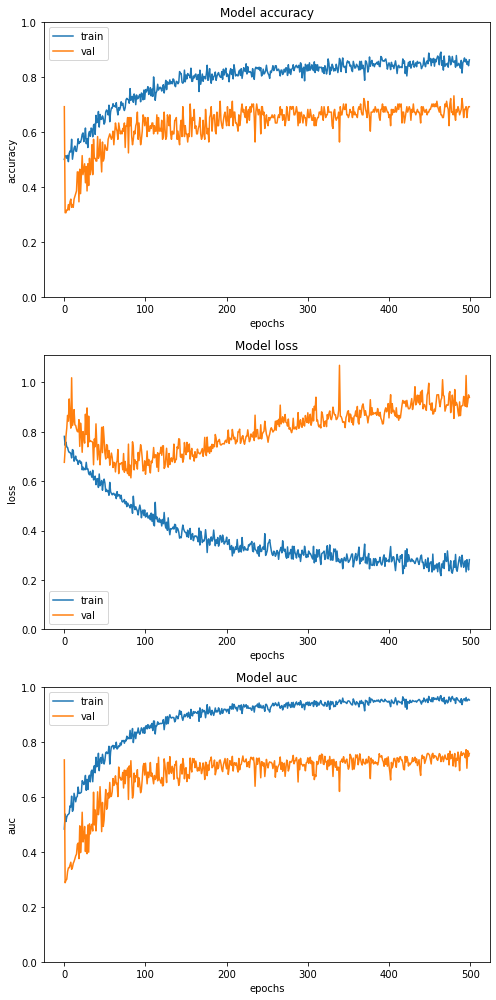

In [234]:
dat = pd.read_csv('results.csv', index_col='epoch')

fig, ax = plt.subplots(3, 1, figsize=(7,14))
metrics = ['accuracy', 'loss', 'auc']

for i, metric in enumerate(metrics):
    ax[i].plot(dat[metric])
    ax[i].plot(dat['val_'+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
    if metric == 'accuracy' or metric == 'auc':
        ax[i].set_ylim(0,1)
        
    else:
        ax[i].set_ylim(0)
    
fig.tight_layout()
plt.show()

p = 'softmax'+str(IMAGE_DIMENSION)
fig.savefig(p)

#### Prediction on test data

In [247]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss))[0][0] 
print(best_model)
best_model = np.where(dat.val_auc == np.max(dat.val_auc))[0][0]
#best_model = np.where(dat.val_accuracy == np.max(dat.val_accuracy))[0][0]
model.load_weights('History/model.epoch' + str(best_model) + '.hdf5')

y_prob = model.predict(X_test, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_test = Y_test.argmax(axis = 1) 

82


In [248]:
auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_test,
    y_scores=y_prob[:,1])

In [249]:
cm = confusion_matrix(y_test, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

In [250]:
print("Accuracy: ", round((np.mean(y_pred == y_test)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_test, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_test, y_pred, normalize = 'true'),3))

Accuracy:  68.32  CI: [0.587 0.766]
AUC:  0.664 CI: [0.547 0.78 ]
Confusion matrix: 
 [[13 18]
 [14 56]]
Normalized Confusion matrix: 
 [[0.419 0.581]
 [0.2   0.8  ]]


In [360]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

#### Prediction on training data

In [358]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss))[0][0] 
print(best_model)
#best_model = np.where(dat.val_auc == np.max(dat.val_auc))[0][0]
#best_model = np.where(dat.val_accuracy == np.max(dat.val_accuracy))[0][0]
model.load_weights('History/model.epoch' + str(best_model) + '.hdf5')

y_prob = model.predict(X_train, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_train = Y_train.argmax(axis = 1) 

63


In [359]:
cm = confusion_matrix(y_train, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

In [293]:
auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_train,
    y_scores=y_prob[:,1])

In [360]:
print("Accuracy: ", round((np.mean(y_pred == y_train)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_train, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_train, y_pred, normalize = 'true'),3))

Accuracy:  88.94  CI: [0.855 0.916]
AUC:  0.658 CI: [0.544 0.771]
Confusion matrix: 
 [[126   0]
 [ 45 236]]
Normalized Confusion matrix: 
 [[1.   0.  ]
 [0.16 0.84]]


In [361]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


#### Prediction on balanced test data

In [362]:
bool_test_labels = Y_test[:,1] != 0
pos_features_test = X_test[bool_test_labels]
neg_features_test = X_test[~bool_test_labels]
pos_labels_test = Y_test[bool_test_labels]
neg_labels_test = Y_test[~bool_test_labels]

In [363]:
ids = np.arange(len(neg_features_test))
choices = np.random.choice(ids, len(pos_features_test))
res_neg_features = neg_features_test[choices]
res_neg_labels = neg_labels_test[choices]

resampled_features = np.concatenate([res_neg_features, pos_features_test], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels_test], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
X_test_balanced = resampled_features[order]
Y_test_balanced  = resampled_labels[order]

In [364]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss))[0][0] 
print(best_model)
#best_model = np.where(dat.val_auc == np.max(dat.val_auc))[0][0]
#best_model = np.where(dat.val_accuracy == np.max(dat.val_accuracy))[0][0]
model.load_weights('History/model.epoch' + str(best_model) + '.hdf5')

y_prob = model.predict(X_test_balanced, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_test_balanced = Y_test_balanced.argmax(axis = 1) 

63


In [365]:
cm = confusion_matrix(y_test_balanced, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_test_balanced,
    y_scores=y_prob[:,1])

In [366]:
print("Accuracy: ", round((np.mean(y_pred == y_test_balanced)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_test_balanced, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_test_balanced, y_pred, normalize = 'true'),3))

Accuracy:  69.29  CI: [0.612 0.763]
AUC:  0.73 CI: [0.646 0.814]
Confusion matrix: 
 [[51 19]
 [24 46]]
Normalized Confusion matrix: 
 [[0.729 0.271]
 [0.343 0.657]]
